# Initial Model - Score Regression

For the initial model, we'll use a machine learning algorithm to predict the severity score that we derived previously. This severity score function increases as:
- The number of referrals increases
- The density of referrals increases

and decreases with each `break` defined as a referral free period longer than 28 days

It is also scaled so that different time scales can be considered together.

First: Some imports

In [64]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns

from scipy.stats import beta, spearmanr
from datetime import datetime

# Problem set-up
Load the data

In [115]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')


clients = pd.read_csv('../../Welcome-Centre-DataCorps-Data/clients.csv', index_col=0)

referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])
    
referrals = referrals.sort_values('ReferralTakenDate')

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
def get_score(referrals, break_length=28, break_coefficient=1, min_beta_fit_days=365):
    gaps = (referrals.sort_values('ReferralTakenDate').groupby('ClientId')['ReferralTakenDate'].diff().dt.days > break_length).groupby(referrals['ClientId']).sum()
    days_active = (referrals['ReferralTakenDate'].max() - referrals.groupby('ClientId')['ReferralTakenDate'].min()).dt.days + 7
    weeks_active = days_active / 7
    referrals = (referrals.groupby('ClientId').size())
    simple_ratio = (referrals - gaps) / weeks_active
    a, b, loc, scale = beta.fit((simple_ratio[days_active > min_beta_fit_days]).values)
    adjusted_ratio = ((referrals - gaps * break_coefficient + a) / (weeks_active + a + b)).sort_values()
    score_df = pd.concat([referrals, gaps, weeks_active, simple_ratio, adjusted_ratio], axis=1)
    score_df.columns=['Referrals', 'Gaps', 'Weeks Active', 'Simple Ratio', 'Empirical Bayes Ratio']
    return score_df.sort_values('Empirical Bayes Ratio')

In [15]:
scores = get_score(referrals)

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [17]:
#best clients
scores.head(5)

,Referrals,Gaps,Weeks Active,Simple Ratio,Empirical Bayes Ratio
ClientId,,,,,
419,3,2.0,217.857143,0.00459,0.0053
138,2,1.0,217.857143,0.00459,0.0053
143,2,1.0,217.857143,0.00459,0.0053
336,2,1.0,217.857143,0.00459,0.0053
1056,5,4.0,217.857143,0.00459,0.0053


In [18]:
#worst clients
scores.tail(5)

,Referrals,Gaps,Weeks Active,Simple Ratio,Empirical Bayes Ratio
ClientId,,,,,
5201,33,0.0,31.142857,1.059633,0.261161
4606,43,0.0,59.571429,0.721823,0.277528
3711,56,2.0,94.000000,0.574468,0.285063
2890,91,4.0,137.000000,0.635036,0.373406
287,108,8.0,171.142857,0.584307,0.374338


# Some Exploration

We want to be able to predict the eventual severity of a client's usage from there initial few referrals.

How do various features correlate with severity, say, for the first few referrals

In [30]:
referral_no = referrals.assign(count=1).groupby('ClientId').expanding()['count'].sum()
referral_no = referral_no.reset_index().set_index('level_1')['count']

In [32]:
subset = referrals[referral_no < 10]

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [243]:
def get_feature_matrix(referrals, clients):
    general = referrals[['DependantNumber', 'LivingWithPartner']]
    current_issues = get_current_referral_issues(referrals)
    any_issue = current_issues.groupby(subset['ClientId'], as_index=False, sort=False).expanding().sum() > 0
    any_issue.index = any_issue.index.droplevel(0)
    any_issue = any_issue.loc[referrals.index]
    referral_issues = pd.concat([general, current_issues.add_prefix('current_'), 
                      any_issue.add_prefix('ever_')], axis=1)
    client_issues = get_client_features(clients).loc[referrals['ClientId']]
    client_issues.index = referrals.index
    return pd.concat([referral_issues, client_issues], axis=1)

In [157]:
def get_current_referral_issues(referrals):
    referral_reasons = referrals.filter(like='ReferralDomestic').add_prefix('reasons_')
    referral_document = referrals.filter(like='ReferralDocument').add_prefix('documents_')
    referral_benefit = referrals.filter(like='ReferralBenefit').add_prefix('benefit_')
    referral_issue = referrals.filter(like='ReferralIssue').add_prefix('r_issue_')
    referral_reason = referrals.filter(like='ReferralReason').add_prefix('reason_')
    client_issue = referrals.filter(like='ClientIssue').add_prefix('c_issue_')
    referral_agency = pd.get_dummies(referrals['ReferralAgencyId']).add_prefix('agency_')

    X = pd.concat([
        referral_reasons,
        referral_document,
        referral_benefit,
        referral_issue,
        referral_reason,
        referral_agency,
        client_issue
    ], axis=1).fillna(False).astype(bool)
    
    return X

In [165]:
def get_client_features(clients):
    clients['ClientDateOfBirth'] = pd.to_datetime(clients['ClientDateOfBirth'])
    clients['AddressSinceDate'] = pd.to_datetime(clients['AddressSinceDate'])
    clients['Age'] = datetime.now() - clients['ClientDateOfBirth']
    clients['Age'] = clients['Age'].dt.days / 365
    clients.loc[clients['Age'] < 0, 'Age'] += 100
    clients['AddressLength'] = (datetime.now() - clients['AddressSinceDate']).dt.days / 365
    categories = pd.get_dummies(clients[['EthnicityDescription', 'ClientCountryID', 'ClientAddressTypeDescription', 'AddressPostCode', 
        'LocalityDescription', 'ResidencyDescription']].astype(str))
    clients['known_partner'] = clients['PartnerId'].notnull()

    client_features = pd.concat([clients[['Age', 'AddressLength', 'ClientIsMale', 'known_partner']], 
              categories], axis=1)
    client_features = client_features.fillna(client_features.median())
    return client_features

# Correlations

To sense check our system, let's consider looking at correlations.

If a correlation is positive, it means that when the values move in the same direction. For example, if Age is positively correlated to dependency, it would mean that older people are more likely to be dependent.

Similarly, even if the variable can take only two values, for example `is_male`, if that is positive, then it means males are more likely to be dependent.

Negative correlation implies the opposite effect

## Client Features

We look at the correlation between aspects of the client and the severity, creating features for aspects stored in the client table.

Do they line up to expectation?

In [174]:
client_features = get_client_features(clients)

client_features, bayes_score = client_features.align(scores['Empirical Bayes Ratio'], 'inner', 0)

client_features.apply(lambda k: spearmanr(bayes_score, k)[0]).sort_values().dropna()

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


AddressLength                                       -0.321583
ResidencyDescription_nan                            -0.183675
ClientAddressTypeDescription_Permanent              -0.134244
EthnicityDescription_White - British                -0.101761
ClientCountryID_nan                                 -0.090892
LocalityDescription_Dewsbury                        -0.080411
AddressPostCode_WF14                                -0.063139
LocalityDescription_Mirfield                        -0.061274
AddressPostCode_WF17                                -0.058797
AddressPostCode_WF12                                -0.058725
LocalityDescription_Batley                          -0.057303
AddressPostCode_WF15                                -0.056681
LocalityDescription_Liversedge                      -0.054246
AddressPostCode_WF13                                -0.044602
AddressPostCode_WF16                                -0.042508
LocalityDescription_Rawthorpe                       -0.039356
Locality

## Adding in simple referral features

We create features for referrals, using only the categorical datapoints.

We consider both:
- The current referral reasons/issues/etc.
- All given referral reasons up until that point

In [238]:
current_issues = get_current_referral_issues(subset)

In [239]:
aligned_score = scores['Empirical Bayes Ratio'].loc[subset['ClientId']].to_frame().set_index(subset.index)

In [240]:
current_issues.apply(lambda k: spearmanr(aligned_score.iloc[:,0], k)[0]).sort_values()

agency_86                                                           -0.123583
agency_45                                                           -0.061805
c_issue_ClientIssue_Estranged                                       -0.061243
agency_13                                                           -0.050352
agency_20                                                           -0.050011
agency_77                                                           -0.045763
reason_ReferralReason_Housing Issues - New Tenancy                  -0.044678
reason_ReferralReason_Bills - Utilities (Gas, Electricity, Water)   -0.042703
agency_103                                                          -0.041373
agency_36                                                           -0.038724
agency_29                                                           -0.037523
agency_1                                                            -0.037358
reason_ReferralReason_Domestic Issues                           

In [241]:
any_issue = X.groupby(subset['ClientId'], as_index=False, sort=False).expanding().sum() > 0
any_issue.index = any_issue.index.droplevel(0)
any_issue = any_issue.loc[subset.index]
any_issue.apply(lambda k: spearmanr(aligned_score.iloc[:,0], k)[0]).sort_values()

c_issue_ClientIssue_Estranged                                       -0.061243
agency_20                                                           -0.044521
agency_13                                                           -0.043778
agency_45                                                           -0.035421
agency_34                                                           -0.033133
agency_93                                                           -0.032458
agency_78                                                           -0.029204
agency_1                                                            -0.027886
agency_52                                                           -0.026786
agency_102                                                          -0.026775
agency_24                                                           -0.023520
agency_90                                                           -0.019973
agency_116                                                      

Domestic Circumstances - Cooking - All Facilities seems a little strange. Other than that, benefit changes are lead to some level of dependence

## Referral No.

As referral no. is a component of our score, it should have a very high correlation with score. 

In [188]:
referral_no.loc[subset.index].to_frame().corrwith(aligned_score.iloc[:,0])

count    0.348207
dtype: float64

# A simple model

In [190]:
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [191]:
# Define scoring function
scoring_function = make_scorer(lambda a,b: spearmanr(a,b)[0])

In [192]:
# Create Model Pipeline
pipe = Pipeline([
    ('imp', Imputer()),
    ('scale', StandardScaler()),
    ('reg', Ridge())
])

In [198]:
y = aligned_score.loc[subset.index].iloc[:,0]

## Baseline Model

Referral No. only

In [220]:
# Fit Logistic Regression
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring=scoring_function, verbose=3)
gs.fit(referral_no.loc[subset.index].values.reshape(-1,1), aligned_score.iloc[:,0])

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] reg__alpha=1e-05 ................................................
[CV] ........ reg__alpha=1e-05, score=0.466846617966426, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.5978072480442522, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.5435435805234949, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.5557287407493705, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.4815607580671371, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.4641458127722802, total=   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... reg__alpha=0.001, score=0.4815607580671371, total=   0.0s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.4641458127722802, total=   0.0s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.4563953514107903, total=   0.0s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.3807380330335314, total=   0.0s
[CV] reg__alpha=0.001 ................................................
[CV] ...... reg__alpha=0.001, score=0.34485718884180694, total=   0.0s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.2153137874653421, total=   0.0s
[CV] reg__alpha=0.01 .................................................
[CV] ......... reg__alpha=0.01, score=0.466846617966426, total=   0.0s
[CV] reg__alpha=0.01 .................................................
[CV] .

[CV] ..... reg__alpha=10000.0, score=0.2153137874653421, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] ..... reg__alpha=100000.0, score=0.466846617966426, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .... reg__alpha=100000.0, score=0.5978072480442522, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .... reg__alpha=100000.0, score=0.5435435805234949, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .... reg__alpha=100000.0, score=0.5557287407493705, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .... reg__alpha=100000.0, score=0.4815607580671371, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .... reg__alpha=100000.0, score=0.4641458127722802, total=   0.0s
[CV] reg__alpha=100000.0 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg__alpha': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(<lambda>), verbose=3)

As expected, referral number is very predictive:

Achieving a spearman correlation of:

In [221]:
gs.best_score_

0.45069371188744312

In [ ]:
res = pd.concat([np.log(bayes_score), pd.Series(pred, index=bayes_score.index, name='prediction')], axis=1)

# Client Features Only

In [212]:
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring=scoring_function, verbose=3)
gs.fit(client_features, np.log(bayes_score))

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] reg__alpha=1e-05 ................................................
[CV] ...... reg__alpha=1e-05, score=0.23470232206881494, total=   0.3s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...... reg__alpha=1e-05, score=0.27981505295037756, total=   0.3s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ...... reg__alpha=1e-05, score=0.14840135725357667, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.2621959701848784, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ..... reg__alpha=1e-05, score=0.043644263967359265, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ...... reg__alpha=1e-05, score=0.21815010955484787, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.1846710235194157, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ........ reg__alpha=1e-05, score=0.226314858771669, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] ....... reg__alpha=1e-05, score=0.2944801323139683, total=   0.3s
[CV] reg__alpha=1e-05 ................................................
[CV] .

[CV] ........ reg__alpha=10.0, score=0.2348760624425344, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ....... reg__alpha=10.0, score=0.27995577103149527, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ....... reg__alpha=10.0, score=0.14834344312283373, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ....... reg__alpha=10.0, score=0.26214580148295147, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ...... reg__alpha=10.0, score=0.043538840620022515, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ....... reg__alpha=10.0, score=0.21828520131334814, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] ....... reg__alpha=10.0, score=0.18504749291164643, total=   0.3s
[CV] reg__alpha=10.0 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   46.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg__alpha': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(<lambda>), verbose=3)

In [219]:
gs.best_score_

0.20999381921758942

In [213]:
from sklearn.model_selection import cross_val_predict

pred = cross_val_predict(gs.best_estimator_, client_features, np.log(bayes_score), cv=10)

In [214]:
import seaborn as sns
%matplotlib inline

In [215]:
res = pd.concat([np.log(bayes_score), pd.Series(pred, index=bayes_score.index, name='prediction')], axis=1)

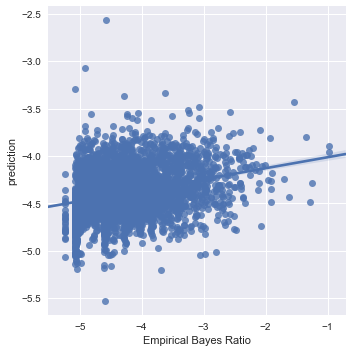

In [218]:
sns.lmplot('Empirical Bayes Ratio', 'prediction', res)

In [244]:
all_features = get_feature_matrix(subset, clients)

In [249]:
all_features.apply(lambda k: spearmanr(k, aligned_score.iloc[:,0])[0]).sort_values()

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


AddressLength                                                               -0.278357
ResidencyDescription_nan                                                    -0.183495
current_agency_86                                                           -0.123583
ClientAddressTypeDescription_Permanent                                      -0.087701
ClientCountryID_nan                                                         -0.074379
DependantNumber                                                             -0.072873
EthnicityDescription_White - British                                        -0.071158
current_agency_45                                                           -0.061805
current_c_issue_ClientIssue_Estranged                                       -0.061243
ever_c_issue_ClientIssue_Estranged                                          -0.061243
AddressPostCode_WF17                                                        -0.053857
ClientCountryID_5.0                                   

In [255]:
all_features.assign(ref_no=referral_no)

,DependantNumber,LivingWithPartner,current_reasons_ReferralDomesticCircumstances_Cooking - All Facilities,current_reasons_ReferralDomesticCircumstances_Cooking - Hob,current_reasons_ReferralDomesticCircumstances_Cooking - Kettle,current_reasons_ReferralDomesticCircumstances_Cooking - Microwave,current_reasons_ReferralDomesticCircumstances_Non-Cook - NFA,current_reasons_ReferralDomesticCircumstances_Non-Cook - Non-cook at home,current_documents_ReferralDocument_Benefit Issue letter,current_documents_ReferralDocument_Crime Number,...,LocalityDescription_nan,ResidencyDescription_Asylum Seeker,ResidencyDescription_Destitute,ResidencyDescription_Migrant,ResidencyDescription_New to area,ResidencyDescription_North Kirklees,ResidencyDescription_Refugee with leave to stay,ResidencyDescription_South Kirklees Resident,ResidencyDescription_nan,ref_no
499,0,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
1101,0,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
627,0,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
423,1,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
950,4,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
247,1,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
439,1,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0
1143,0,0,False,False,False,False,False,False,False,False,...,1,0,0,0,0,0,0,0,1,1.0
1209,0,0,False,False,False,False,False,False,False,False,...,1,0,0,0,0,0,1,0,0,1.0
242,4,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,1.0


In [257]:
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=3, scoring=scoring_function, verbose=3)
gs.fit(all_features.assign(ref_no=referral_no), aligned_score.iloc[:,0])

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] reg__alpha=1e-05 ................................................
[CV] ...... reg__alpha=1e-05, score=0.44857310740814427, total=   1.8s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] ....... reg__alpha=1e-05, score=0.4858300666059362, total=   1.7s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV] ....... reg__alpha=1e-05, score=0.4494328785976336, total=   1.8s
[CV] reg__alpha=0.0001 ...............................................
[CV] ...... reg__alpha=0.0001, score=0.4485731986108547, total=   1.7s
[CV] reg__alpha=0.0001 ...............................................
[CV] ...... reg__alpha=0.0001, score=0.4858300666059362, total=   1.7s
[CV] reg__alpha=0.0001 ...............................................
[CV] ...... reg__alpha=0.0001, score=0.4494328785976336, total=   1.7s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.4485733467267013, total=   1.7s
[CV] reg__alpha=0.001 ................................................
[CV] ....... reg__alpha=0.001, score=0.4858300666059362, total=   1.7s
[CV] reg__alpha=0.001 ................................................
[CV] ...... reg__alpha=0.001, score=0.44943304301152287, total=   1.7s
[CV] reg__alpha=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg__alpha': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(<lambda>), verbose=3)

In [258]:
gs.best_params_, gs.best_score_

({'reg__alpha': 10000.0}, 0.47793001131081969)

In [252]:
gs.best_params_, gs.best_score_

({'reg__alpha': 10000.0}, 0.47051962262972352)

In [261]:
pd.Series(gs.best_estimator_.steps[-1][1].coef_.ravel(), all_features.assign(ref_no=referral_no).columns).sort_values()

AddressLength                                                            -0.002438
ResidencyDescription_nan                                                 -0.000856
AddressPostCode_HD2 2                                                    -0.000650
current_benefit_ReferralBenefit_ESA (Employment Support Allowance)       -0.000616
LocalityDescription_Bradley; Huddersfield                                -0.000556
ever_benefit_ReferralBenefit_NASS Payments                               -0.000545
ClientCountryID_7.0                                                      -0.000545
ever_reason_ReferralReason_Money Lost/Stolen                             -0.000518
ever_reason_ReferralReason_Domestic Issues                               -0.000508
ClientCountryID_5.0                                                      -0.000495
EthnicityDescription_White - British                                     -0.000483
ClientCountryID_nan                                                      -0.000481
curr

# Each Point Calculation

In [342]:
from tqdm import tqdm_notebook

In [344]:
def look_ahead_ratios(referrals, window=365, break_length=28, break_coefficient=1, min_beta_fit_days=90):
    all_ratios = []
    for i in tqdm_notebook(range(1, int(referral_no.max()))):
        segment = referrals.loc[referral_no==i,:]
        reference_date = segment.set_index('ClientId')['ReferralTakenDate']
        referrals = referrals.assign(reference_date=reference_date.loc[referrals.ClientId].values)
        date_diff = (referrals['ReferralTakenDate']-referrals['reference_date']).dt.days
        year_range = referrals[(date_diff > 0) & (date_diff <= window)]

        gaps = (year_range.sort_values('ReferralTakenDate').groupby('ClientId')['ReferralTakenDate'].diff().dt.days > break_length).groupby(year_range['ClientId']).sum()
        days_active = ((year_range['ReferralTakenDate'].max() - year_range.groupby('ClientId')['ReferralTakenDate'].min()).dt.days + 7).clip(0, window)
        weeks_active = days_active / 7
        counts = (year_range.groupby('ClientId').size())
        simple_ratio = (counts - gaps * break_coefficient) / weeks_active
        segment_ratios = pd.concat([counts, simple_ratio, days_active, gaps, weeks_active], axis=1).loc[segment.ClientId]
        segment_ratios.columns = ['counts', 'simple', 'days', 'gaps', 'weeks']
        segment_ratios.index = segment.index
        all_ratios.append(segment_ratios)

    all_ratios_df = pd.concat(all_ratios)

    a, b, loc, scale = beta.fit(all_ratios_df[all_ratios_df['days'] > min_beta_fit_days]['simple'].values)

    adjusted_ratio = ((all_ratios_df['counts'] - all_ratios_df['gaps'] * break_coefficient + a) / (all_ratios_df['weeks'] + a + b)).sort_values()
    score_df = pd.concat([all_ratios_df, adjusted_ratio], axis=1)
    return score_df.sort_values(0).dropna()

In [346]:
look_ahead_score = look_ahead_ratios(referrals)

/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jamesgin/.virtualenvs/datasine/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
